# Digits dataset - Multiclass classifier
## High-level steps: 
1. Train a classifier on Digits dataset 
2. Check ROC-AUC 
3. Choose optimal threshold 
4. Save Model, Scaler and Class Thresholds persistently
5. Load model with thresholds for inference 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

## Step 1: Load Libraries and Dataset

In [2]:
# Load the dataset
digits = load_digits()
X, y = digits.data, digits.target

# Binarize the output (one-hot encoding for ROC)
y_bin = label_binarize(y, classes=np.unique(y))

# Number of classes
n_classes = y_bin.shape[1]

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42, stratify=y_bin)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Lets visualise the training data 

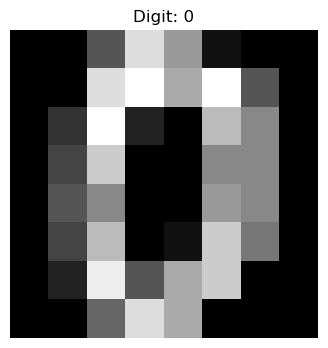

Numerical Representation (8x8 Matrix):
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [6]:

# Pick a sample image (e.g., index 0)
sample_index = 0
sample_image = digits.images[sample_index]  # Original 8x8 image
sample_data = digits.data[sample_index]    # Flattened 64-pixel feature vector

# Show the image
plt.figure(figsize=(4, 4))
plt.imshow(sample_image, cmap='gray')
plt.title(f"Digit: {digits.target[sample_index]}")
plt.axis('off')
plt.show()

# Print the numerical representation (8x8 pixel values)
print("Numerical Representation (8x8 Matrix):")
print(np.array_str(sample_image, precision=1, suppress_small=True))

## Step 2: Train Logistic Regression Model

In [3]:
# Train a One-vs-Rest Logistic Regression model
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
clf.fit(X_train, y_train)

# Get prediction probabilities
y_score = clf.decision_function(X_test)


In [12]:
# first row of y_score
print(y_score[0])

[ -7.46521355  -6.71508074  -2.75698639  -8.31769652  -5.23421152
 -10.77762201  -0.5643495   -5.1354674    1.66188527  -7.61939948]


In [10]:
# shape of X_test: (n_samples, n_features)
print(f"Shape of X_test: {X_test.shape}")   


Shape of X_test: (540, 64)


In [16]:
y_proba = clf.predict_proba(X_test) 
y_pred = clf.predict(X_test)

In [17]:
# i want to see first row of y_proba
print(y_proba[0])
print(y_pred[0])

[5.72335013e-04 1.21101977e-03 5.96932959e-02 2.44098030e-04
 5.30275707e-03 2.08607142e-05 3.62541667e-01 5.84987808e-03
 8.40490916e-01 4.90595697e-04]
[0 0 0 0 0 0 0 0 1 0]


## Step 3: Compute and Plot the ROC-AUC Curve


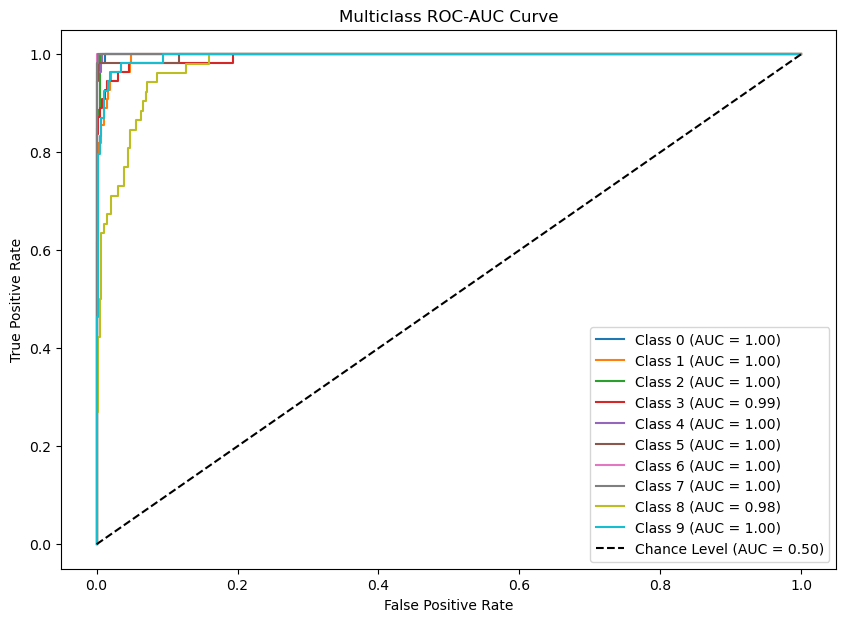

In [4]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal (random guessing)
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.50)')

# Formatting the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC-AUC Curve')
plt.legend()
plt.show()


## Step 4: Compute Average AUC Score

In [5]:
from sklearn.metrics import roc_auc_score

# Compute the average AUC score
macro_roc_auc = roc_auc_score(y_test, y_score, average="macro")
weighted_roc_auc = roc_auc_score(y_test, y_score, average="weighted")

print(f"Macro-Averaged AUC: {macro_roc_auc:.2f}")
print(f"Weighted-Averaged AUC: {weighted_roc_auc:.2f}")


Macro-Averaged AUC: 1.00
Weighted-Averaged AUC: 1.00


## Step 5: Choose the optimal threshold

In [19]:
print(n_classes)

10


In [20]:
# Find the optimal threshold for each class
optimal_thresholds = {}

for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_score[:, i])  # Explicitly name 'thresholds'

    # Compute Youden’s J-statistic: J = TPR - FPR
    J_scores = tpr[i] - fpr[i]
    
    # Find the threshold that maximizes J
    optimal_idx = np.argmax(J_scores)  # Index of the max J score
    optimal_thresholds[i] = thresholds[optimal_idx]  # Use 'thresholds' instead of '_'

# Print optimal thresholds for each class
print("Optimal Thresholds per Class:", optimal_thresholds)


Optimal Thresholds per Class: {0: -1.2697991482186675, 1: -1.4209819861374076, 2: 0.7591928236765071, 3: -1.9667929316270523, 4: -0.7756074263151733, 5: -0.7418872712384781, 6: 1.188901248145089, 7: -0.5909546899649953, 8: -2.1120809916231447, 9: -0.9364701618605897}


## Step 6: Save the Model, Scaler and Thresholds

In [21]:
# Save Model, Scaler and Thresholds 
import joblib
import json  # To save optimal thresholds in a readable format

# Save the trained model
joblib.dump(clf, "logistic_regression_multiclass.pkl")

# Save the scaler
joblib.dump(scaler, "scaler.pkl")

# Save the optimal thresholds as a JSON file
with open("optimal_thresholds.json", "w") as f:
    json.dump(optimal_thresholds, f)

print("Model, Scaler, and Optimal Thresholds Saved Successfully!")


Model, Scaler, and Optimal Thresholds Saved Successfully!


## Step 7: Load the model for new predictions

In [23]:
# Load the trained model
loaded_model = joblib.load("logistic_regression_multiclass.pkl")

# Load the scaler
loaded_scaler = joblib.load("scaler.pkl")

# Load the optimal thresholds
with open("optimal_thresholds.json", "r") as f:
    loaded_thresholds = json.load(f)

# Convert keys back to integers (JSON saves dictionary keys as strings)
loaded_thresholds = {int(k): v for k, v in loaded_thresholds.items()}

print("Model, Scaler, and Thresholds Loaded Successfully!")


Model, Scaler, and Thresholds Loaded Successfully!


## Step 8: Make Predictions with the Loaded Model

In [25]:
# Example: Make predictions on new test data
X_new = X_test[:5]  # Take 5 new test samples
X_new_scaled = loaded_scaler.transform(X_new)  # Apply saved preprocessing
y_new_proba = loaded_model.predict_proba(X_new_scaled)  # Get probability scores

# Apply optimal thresholds to make final predictions
y_new_pred_adjusted = np.zeros_like(y_new_proba)

for i in range(n_classes):
    y_new_pred_adjusted[:, i] = (y_new_proba[:, i] >= loaded_thresholds[i]).astype(int)

# Convert back to class labels
y_new_final = np.argmax(y_new_pred_adjusted, axis=1)

print("Final Predictions:", y_new_final)


Final Predictions: [0 0 0 0 0]
